# Chip Purchasing Type and Behavior of Customers

We are tasked to analyze the transaction and customer data for chips with the goal of gaining insights on what drives chip sales among the different customer segments available.

- LIFESTAGE: Customer attribute that identifies whether a customer has a family or not and what point in life they are at e.g. are their children in pre-school/primary/secondary school.

- PREMIUM_CUSTOMER: Customer segmentation used to differentiate shoppers by the price point of products they buy and the types of products they buy. It is used to identify whether customers may spend more for quality or brand or whether they will purchase the cheapest options.

In [1]:
import re
import xlrd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
from scipy.stats import ttest_ind, linregress

pd.options.mode.chained_assignment = None  

In [2]:
customer_data = pd.read_csv('QVI_purchase_behaviour.csv')
transaction_data = pd.read_excel('QVI_transaction_data.xlsx')

## I. Data Cleaning/Processing

We first look into the records for each dataset. We also check for any `NULL` values.

### Customer Data

In [3]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [4]:
customer_data.nunique()

LYLTY_CARD_NBR      72637
LIFESTAGE               7
PREMIUM_CUSTOMER        3
dtype: int64

In [5]:
customer_data['LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [6]:
customer_data['PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

In [7]:
customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


### Transaction Data

In [8]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [9]:
transaction_data.nunique()

DATE                 364
STORE_NBR            272
LYLTY_CARD_NBR     72637
TXN_ID            263127
PROD_NBR             114
PROD_NAME            114
PROD_QTY               6
TOT_SALES            112
dtype: int64

In [10]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


There does not seem to be any `NULL` values for both datasets. We can, then, proceed in cleaning the data.

### Checking transaction dates
Upon checking the transaction data above, notice that the `DATE` column is in integer format. Excel date starts in the year 1900 while default UNIX date starts at 1970. We take this into account when converting the `DATE` column from integer to datetime.

In [11]:
"------OPTION 1-------------------------------------------------------------------------"

def date_from_Excel(ordinal, epoch_start=datetime(1899, 12, 31)):
    """
    Create a function to convert the Excel dates to datetime format
    
    Returns:
        Date in datetime format
    """
    
    if ordinal >= 60: #if later than Feb, we account for leap year
        ordinal -= 1  #account for Excel leap year bug since 1900 is not a leap year
        
    return epoch_start + timedelta(days=ordinal)

"------OPTION 2-------------------------------------------------------------------------"

def date_convert_xlrd(ordinal):
    """
    Using the xlrd module to create a function to convert the 
    Excel dates to datetime format
    
    NOTE: We can use datetime.date().isoformat() to return
          the date as a string instead
    
    Returns:
        Date in datetime format
    """ 
    
    return xlrd.xldate_as_datetime(ordinal, 0)

In [12]:
#apply the date_from_Excel() function to each row under the DATE column
transaction_data['DATE'] = transaction_data['DATE'].apply(lambda dt: date_convert_xlrd(dt))
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [13]:
max_date = transaction_data['DATE'].max()
min_date = transaction_data['DATE'].min()
num_days = (max_date-min_date).days+1
unique_date = transaction_data['DATE'].unique().size

print(f"Minimum Date: {min_date}\nMaximum Date: {max_date}")
print(f"Total number of days: {num_days}\nUnique date count: {unique_date}")

Minimum Date: 2018-07-01 00:00:00
Maximum Date: 2019-06-30 00:00:00
Total number of days: 365
Unique date count: 364


Further exploring the dates, we notice that the total number of days between the maximum and minimum dates is 365. However, only 364 unique dates are recorded in the transaction. This means, there must be a missing date.

We can find this missing date by first creating the complete dates and joining this to the actual data.

In [14]:
full_date = pd.DataFrame([(min_date + timedelta(days=i)) for i in range(num_days)],columns=['DATE'])
trans_count_date = transaction_data.groupby('DATE').agg({"TXN_ID":"count"}).reset_index()\
                                   .rename(columns={'TXN_ID':'TXN_COUNT'})

#LEFT JOIN actual data to generated dates
merged_dates = full_date.merge(trans_count_date, how='left', on=['DATE'])
merged_dates[merged_dates['TXN_COUNT'].isnull()]

,DATE,TXN_COUNT
177,2018-12-25,NaN


Visually, we can see a disconnected segment in the plot:

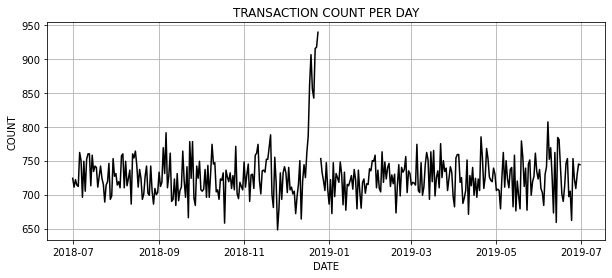

In [15]:
plt.figure(figsize=(10,4))
plt.plot(merged_dates.DATE, merged_dates.TXN_COUNT, color='black')
plt.title('TRANSACTION COUNT PER DAY')
plt.xlabel('DATE')
plt.ylabel('COUNT')
plt.grid()
plt.show()

Alternatively, we can use `sets` to find the missing date. This is relatively faster compared to the previous joining of dataframes.

In [16]:
full_date = [(min_date + timedelta(days=i)).date().isoformat() for i in range(num_days)]
unique_date = transaction_data['DATE'].apply(lambda dt: dt.date().isoformat()).unique().tolist()

#find values found in full_date but not in unique_date
set(full_date) - set(unique_date)

{'2018-12-25'}

The data has no transactions recorded for 2018-12-25. It is probable that the store is closed during Christmas.

We can further see this by plotting the number of sales per month within the given 1-year range (from July 2018 to June 2019).

In [17]:
#create month and year from given dates
transaction_data['YEAR'] = transaction_data['DATE'].dt.year
transaction_data['MONTH_NAME'] = transaction_data['DATE'].dt.month_name()
transaction_data['MONTH'] = transaction_data['DATE'].dt.month
transaction_data['DAY'] = transaction_data['DATE'].dt.day

sales_per_month = transaction_data.groupby(['YEAR','MONTH_NAME','MONTH'])\
                                  .agg({'TXN_ID':'count'}).reset_index()\
                                  .rename(columns={'TXN_ID':'COUNT'})\
                                  .sort_values(['YEAR','MONTH'])[['MONTH_NAME','COUNT']]

sales_dec = transaction_data[transaction_data['MONTH_NAME']=='December'].groupby('DAY')\
                                  .agg({'TXN_ID':'count'}).reset_index()\
                                  .rename(columns={'TXN_ID':'COUNT'})\
                                  .sort_values('DAY')

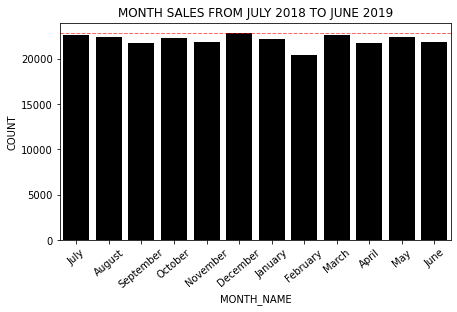

In [18]:
plt.figure(figsize=(7,4))

max_sales = sales_per_month['COUNT'].max()
g = sns.barplot(data=sales_per_month, x='MONTH_NAME', y='COUNT', color='black')
g.set_xticklabels(g.get_xticklabels(), rotation=40)
# plt.xticks(rotation=30)
plt.axhline(y=max_sales, color='red', linestyle='--', linewidth=1, alpha=0.6)
plt.title('MONTH SALES FROM JULY 2018 TO JUNE 2019')
plt.show()

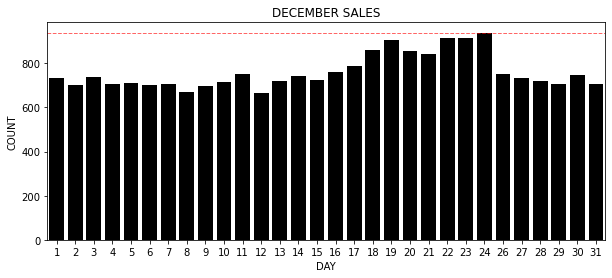

In [19]:
plt.figure(figsize=(10,4))

max_dec_sales = sales_dec['COUNT'].max()
g = sns.barplot(data=sales_dec, x='DAY', y='COUNT', color='black')
plt.axhline(y=max_dec_sales, color='red', linestyle='--', linewidth=1, alpha=0.6)
plt.title('DECEMBER SALES')
plt.show()

To visualize this better, we add December 25 with 0 counts:

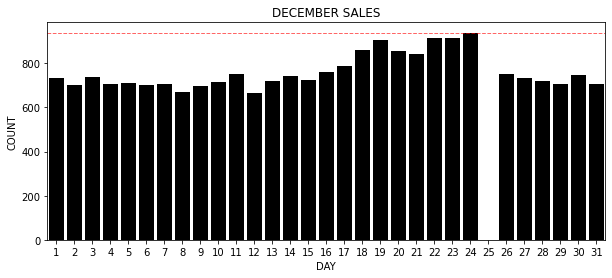

In [20]:
plt.figure(figsize=(10,4))

sales_dec.loc[len(sales_dec.index)] = [25, 0]
g = sns.barplot(data=sales_dec.sort_values('DAY'), x='DAY', y='COUNT', color='black')
plt.axhline(y=max_dec_sales, color='red', linestyle='--', linewidth=1, alpha=0.6)
plt.title('DECEMBER SALES')
plt.show()

No sales are recorded for December 25 since the store is probably closed. Moreover, there seemed to be a spike in the number of sales on the days leading to Christmas -- most notably on December 22 to 24 with December 24 having the highest sales for the month.

### Separating and filtering` PROD_NAME`

In [21]:
print("Unique products:", transaction_data['PROD_NAME'].unique().size)

Unique products: 114


In [22]:
transaction_data['PROD_NAME'].unique()[:5]

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g'], dtype=object)

We can separate the product names from the product sizes by using pandas `extract()` with this string pattern: `extract(r'(\D+)(\d+)')`. <u>This assumes that the product sizes are always found at the end of the product names</u>. However, in the case that it is not, we better extract only the values in the `PROD_NAME` column using `extract(r'(\d+)')`

In [23]:
#separate the product names from the product sizes
transaction_data.loc[:, 'PROD_SIZE (g)'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)')\
                                                                        .rename(columns={0:'PROD_SIZE (g)'})

#remove extra whitespaces for easier name searching (for some reason, strip() does not work)
transaction_data.loc[:, 'PROD_NAME'] = transaction_data['PROD_NAME'].apply(lambda x: ' '.join(x.split()))\
                                                                    .str.replace(r'\d+g','',case=False)\
                                                                    .str.replace(r'[&/?]','')

transaction_data.loc[:, 'PROD_SIZE (g)'] = transaction_data['PROD_SIZE (g)'].astype(int)

In [24]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,YEAR,MONTH_NAME,MONTH,DAY,PROD_SIZE (g)
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,2018,October,10,17,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,2019,May,5,14,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,2019,May,5,20,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly SCreamOnion,5,15.0,2018,August,8,17,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHnyJlpno Chili,3,13.8,2018,August,8,18,150


We can further explore the product name and see if there are products we would like to remove. We can use a WordCloud to easily visualize the words:

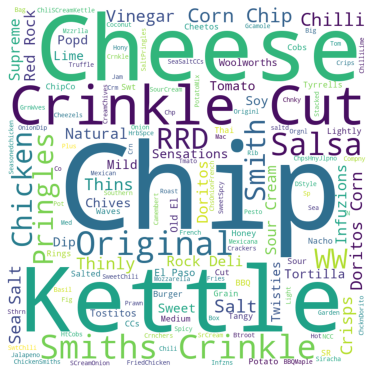

In [25]:
prod_name_str = ''.join(transaction_data['PROD_NAME'].unique())
wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white',
                      min_font_size = 10).generate(prod_name_str)

# plot the WordCloud image                      
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

From the `PROD_NAME`, notice that there are products which are not chips, i.e. salsa. We will remove these products and separate the product sizes from the product names.

In [26]:
#remove products with salsa since we only want chips
chip_trns_data = transaction_data[~transaction_data['PROD_NAME'].str.contains('salsa', case=False)]
print(f"Unique products: {chip_trns_data['PROD_NAME'].unique().size}")

Unique products: 105


The brand of the chips are also included in the `PROD_NAME`. For this purpose, we assume that the first word of each product name corresponds to its brand name. We further separate this from the product name.

In [27]:
chip_trns_data['BRAND_NAME'] = chip_trns_data['PROD_NAME'].str.extract(r'(^\w+)')
chip_trns_data['BRAND_NAME'].value_counts()

Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: BRAND_NAME, dtype: int64

In [28]:
chip_trns_data[(chip_trns_data['BRAND_NAME']=='Red')|(chip_trns_data['BRAND_NAME']=='RRD')
               |(chip_trns_data['BRAND_NAME']=='Dorito')|(chip_trns_data['BRAND_NAME']=='Doritos')].sample(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,YEAR,MONTH_NAME,MONTH,DAY,PROD_SIZE (g),BRAND_NAME
211377,2018-08-27,153,153298,153150,30,Doritos Corn Chips Cheese Supreme,2,8.8,2018,August,8,27,170,Doritos
54592,2019-05-11,262,262215,262528,51,Doritos Mexicana,2,8.8,2019,May,5,11,170,Doritos
161495,2018-12-18,136,136485,138855,42,Doritos Corn Chip Mexican Jalapeno,1,3.9,2018,December,12,18,150,Doritos
205402,2019-06-10,26,26103,22717,47,Doritos Corn Chips Original,2,8.8,2019,June,6,10,170,Doritos
95147,2018-11-03,209,209245,208894,97,RRD Salt Vinegar,2,6.0,2018,November,11,3,165,RRD


After a quick Google search, we see that *'Red'* and *'RRD'* both corresponds to *'Red Rock Deli'*. Moreover, both *'Dorito'* and *'Doritos'* exist when they are just the same. In these cases, we will need to combine them by replacing all *'Red'* with *'RRD'*, and replacing *'Dorito'* with *'Doritos'*. We also do this for other brand names as listed below:

In [29]:
chip_trns_data['BRAND_NAME'] = chip_trns_data['BRAND_NAME'].str.replace('Red','RRD')
chip_trns_data['BRAND_NAME'] = chip_trns_data['BRAND_NAME'].str.replace('WW','Woolworths')
chip_trns_data['BRAND_NAME'] = chip_trns_data['BRAND_NAME'].str.replace('Snbts','Sunbites')
chip_trns_data['BRAND_NAME'] = chip_trns_data['BRAND_NAME'].str.replace('Grain','GrnWves')
chip_trns_data['BRAND_NAME'] = chip_trns_data['BRAND_NAME'].str.replace('NCC','Natural')
chip_trns_data['BRAND_NAME'] = chip_trns_data['BRAND_NAME'].str.replace('Smith','Smiths')
chip_trns_data['BRAND_NAME'] = chip_trns_data['BRAND_NAME'].str.replace('Infzns','Infuzions')

#using replace to change Dorito to Doritos also changes rows with Doritos into Doritoss
#for this, we get the index first for rows with Dorito and then apply replace()
dorito_index = chip_trns_data[chip_trns_data['BRAND_NAME']=='Dorito'].index
chip_trns_data.loc[dorito_index, 'BRAND_NAME'] = chip_trns_data['BRAND_NAME'].str.replace('Dorito','Doritos')

In [30]:
chip_trns_data[chip_trns_data['TXN_ID']==40208]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,YEAR,MONTH_NAME,MONTH,DAY,PROD_SIZE (g),BRAND_NAME
154106,2019-02-22,43,43231,40208,13,Red Rock Deli Thai ChilliLime,2,5.4,2019,February,2,22,150,RRD


### Joining transaction and customer data
Since customer data does not seem to have any `NULL` values as seen above, we can then proceed to joining the customer data to the transaction data.

In [31]:
chip_data_full = chip_trns_data.merge(customer_data, on='LYLTY_CARD_NBR', how='left')

In [32]:
chip_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 246741
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246742 non-null  datetime64[ns]
 1   STORE_NBR         246742 non-null  int64         
 2   LYLTY_CARD_NBR    246742 non-null  int64         
 3   TXN_ID            246742 non-null  int64         
 4   PROD_NBR          246742 non-null  int64         
 5   PROD_NAME         246742 non-null  object        
 6   PROD_QTY          246742 non-null  int64         
 7   TOT_SALES         246742 non-null  float64       
 8   YEAR              246742 non-null  int64         
 9   MONTH_NAME        246742 non-null  object        
 10  MONTH             246742 non-null  int64         
 11  DAY               246742 non-null  int64         
 12  PROD_SIZE (g)     246742 non-null  int32         
 13  BRAND_NAME        246742 non-null  object        
 14  LIFE

No `NULL` values are present. Hence, we can proceed forward to data analysis.

### Finding Outliers

In [33]:
chip_data_full.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,YEAR,MONTH,DAY,PROD_SIZE (g)
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000,246742.000000,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322,2018.495315,6.534972,15.714179,175.585178
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828,0.499979,3.447867,8.775152,59.434727
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000,2018.000000,1.000000,1.000000,70.000000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000,2018.000000,4.000000,8.000000,150.000000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000,2018.000000,7.000000,16.000000,170.000000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000,2019.000000,10.000000,23.000000,175.000000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000,2019.000000,12.000000,31.000000,380.000000


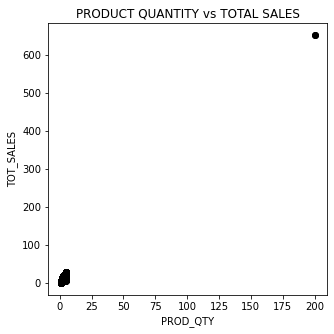

In [34]:
x = chip_data_full['PROD_QTY']
y = chip_data_full['TOT_SALES']

plt.figure(figsize=(5,5))
plt.scatter(x,y, color='black')
plt.xlabel('PROD_QTY')
plt.ylabel('TOT_SALES')
plt.title('PRODUCT QUANTITY vs TOTAL SALES')
plt.show()

There seemed to be an outlier since looking at `PROD_QTY`, the maximum value is at 200 with 75% of the data having values below 2 and a mean of 1.9. `TOT_SALES` also have a large maximum at 650 with only a mean of 7.32. Similarly, looking at the scatter plot for `PROD_QTY` and `TOT_SALES`, most data points are located at the lower-left corner of the graph.

We, then, check this outlier:

In [35]:
chip_data_full[chip_data_full['PROD_QTY']==200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,YEAR,MONTH_NAME,MONTH,DAY,PROD_SIZE (g),BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
64955,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,2018,August,8,19,380,Doritos,OLDER FAMILIES,Premium
64956,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,2019,May,5,20,380,Doritos,OLDER FAMILIES,Premium


Check if customer 226000 made other purchases aside from the above:

In [36]:
chip_data_full[chip_data_full['LYLTY_CARD_NBR']==226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,YEAR,MONTH_NAME,MONTH,DAY,PROD_SIZE (g),BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
64955,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,2018,August,8,19,380,Doritos,OLDER FAMILIES,Premium
64956,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,2019,May,5,20,380,Doritos,OLDER FAMILIES,Premium


The purchase of 200 pieces of chips (specifically, Dorito Corn Chp Supreme) was made by the same account on 2 separate occasions. This might be a one-time bulk purchase per year for customer with `LYLTY_CARD_NBR = 226000`. Since these are only 2-time transactions from the same customer, we can remove this data from our dataset:

In [37]:
#dataset without the above outliers
chip_data_full = chip_data_full[chip_data_full['LYLTY_CARD_NBR'] != 226000]
chip_data_full.shape

(246740, 16)

In [38]:
chip_data_full.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,YEAR,MONTH,DAY,PROD_SIZE (g)
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000,246740.000000,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113,2018.495315,6.534972,15.714148,175.583521
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897,0.499979,3.447878,8.775181,59.432118
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000,2018.000000,1.000000,1.000000,70.000000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000,2018.000000,4.000000,8.000000,150.000000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000,2018.000000,7.000000,16.000000,170.000000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000,2019.000000,10.000000,23.000000,175.000000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000,2019.000000,12.000000,31.000000,380.000000


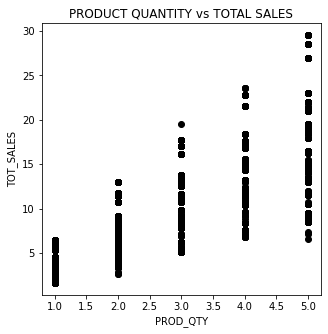

In [39]:
x = chip_data_full['PROD_QTY']
y = chip_data_full['TOT_SALES']

plt.figure(figsize=(5,5))
plt.scatter(x,y,color='black')
plt.xlabel('PROD_QTY')
plt.ylabel('TOT_SALES')
plt.title('PRODUCT QUANTITY vs TOTAL SALES')
plt.show()

The range of values seem to be closer now to each other.

## II. Data Analysis
We will now try to analyze the puchasing behavior of the customer using the following metrics:
- Which type of customer spends the most on chips
- Number of customers per segment
- Number of chips sold per segment
- Average price spent per segment
- Average size of chips sold per segment (determine if chip size is relative to purchase)
- Type/brand of chip that are mostly sold per segment

### Number of chips sold
What chips sold the best? What chips were preferred per customer segment?

In [40]:
chip_sales = chip_data_full.groupby(['PROD_NAME','PROD_SIZE (g)'])\
                           .agg({'PROD_QTY':'sum','TOT_SALES':'sum'})\
                           .reset_index()\
                           .rename(columns={'PROD_QTY':'QTY_SOLD'})\

chip_sales['PRICE_PER_UNIT'] = chip_sales['TOT_SALES']/chip_sales['QTY_SOLD']

In [41]:
chip_sales.sort_values('QTY_SOLD', ascending=False).head()

,PROD_NAME,PROD_SIZE (g),QTY_SOLD,TOT_SALES,PRICE_PER_UNIT
31,Kettle Mozzarella Basil Pesto,175,6381,34457.4,5.4
40,Kettle Tortilla ChpsHnyJlpno Chili,150,6309,29021.4,4.6
8,Cobs Popd Sea Salt Chips,110,6277,23852.6,3.8
10,Cobs Popd SwtChlli SrCream Chips,110,6256,23772.8,3.8
91,Tostitos Splash Of Lime,175,6234,27429.6,4.4


In [42]:
chip_sales.sort_values('TOT_SALES', ascending=False).head()

,PROD_NAME,PROD_SIZE (g),QTY_SOLD,TOT_SALES,PRICE_PER_UNIT
11,Dorito Corn Chp Supreme,380,6109,39052.0,6.392536
79,Smiths Crnkle Chip Orgnl Big Bag,380,6164,36367.6,5.900000
70,Smiths Crinkle Chips Salt Vinegar,330,6106,34804.2,5.700000
31,Kettle Mozzarella Basil Pesto,175,6381,34457.4,5.400000
78,Smiths Crinkle Original,330,6018,34302.6,5.700000


`Kettle Mozzarella Basil Pesto` seems to have the largest number of sales based on `QTY_SOLD`. To dig deeper, we would need to analyze the chip data per customer segment.

### Customers who spend the most on chips

In [43]:
customer_count = customer_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])\
                              .count()\
                              .reset_index()\
                              .rename(columns={'LYLTY_CARD_NBR':'CUSTOMER_COUNT'})\
                              .sort_values('CUSTOMER_COUNT', ignore_index=True, ascending=False)

Prepare bar plot for data visualization:

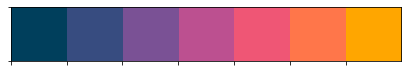

In [44]:
colorList = ['#003f5c',
             '#374c80',
             '#7a5195',
             '#bc5090',
             '#ef5675',
             '#ff764a',
             '#ffa600']

labelList = customer_count.LIFESTAGE.unique()
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colorList,labelList)]

current_palette = sns.color_palette(colorList)
sns.palplot(current_palette)
plt.show()

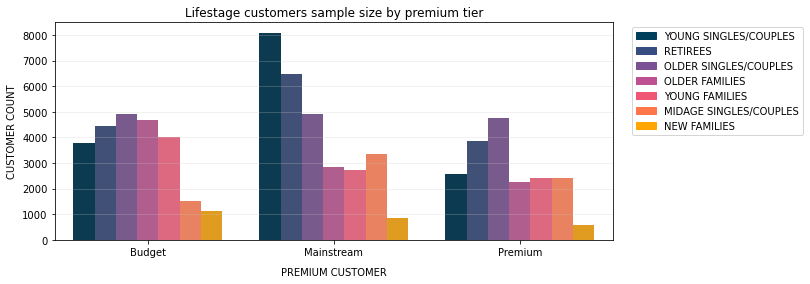

In [45]:
plt.figure(figsize=(10,4))

tierList = ['Budget','Mainstream','Premium']

g = sns.barplot(data=customer_count, 
                x='PREMIUM_CUSTOMER', 
                y='CUSTOMER_COUNT', 
                hue='LIFESTAGE',
                palette=colorList,
                order=tierList,
                hue_order=labelList)
g.set_xticklabels(tierList)
plt.title('Lifestage customers sample size by premium tier')
plt.xlabel('PREMIUM CUSTOMER', labelpad=10)
plt.ylabel('CUSTOMER COUNT', labelpad=5)
plt.grid(axis='y', color='0.80', alpha=0.3)
plt.legend(handles=handles, 
           loc="upper right",
           bbox_to_anchor=(1.35,1))
plt.savefig('results_images/task1_customer_count.png', bbox_inches='tight', dpi=300)
plt.show()

From the data, `YOUNG SINGLES/COUPLES` and `RETIREES` under the `mainstream` tier are the most numerous among customers who buy chips.

In [46]:
lifestage_sales = chip_data_full.groupby(['LIFESTAGE'])\
                                .agg({'PROD_QTY':'sum','TOT_SALES':'sum'})\
                                .reset_index()

lifestage_sales['AVE_SPEND'] = lifestage_sales['TOT_SALES']/lifestage_sales['PROD_QTY']
lifestage_sales.sort_values('AVE_SPEND', ascending=False)

,LIFESTAGE,PROD_QTY,TOT_SALES,AVE_SPEND
1,NEW FAMILIES,12070,47347.95,3.922780
6,YOUNG SINGLES/COUPLES,62300,243756.60,3.912626
4,RETIREES,87875,342381.90,3.896238
0,MIDAGE SINGLES/COUPLES,44496,172523.80,3.877288
3,OLDER SINGLES/COUPLES,97185,376019.65,3.869112
5,YOUNG FAMILIES,78577,294627.90,3.749544
2,OLDER FAMILIES,87896,328519.90,3.737598


By `AVE_SPEND`(price per unit sold), `NEW FAMILIES` and `YOUNG SINGLES/COUPLES` are willing to spend more for chips.

In [47]:
premium_sales = chip_data_full.groupby(['PREMIUM_CUSTOMER'])\
                              .agg({'PROD_QTY':'sum','TOT_SALES':'sum'})\
                              .reset_index()

premium_sales['AVE_SPEND'] = premium_sales['TOT_SALES']/premium_sales['PROD_QTY']
premium_sales.sort_values('AVE_SPEND', ascending=False)

,PREMIUM_CUSTOMER,PROD_QTY,TOT_SALES,AVE_SPEND
1,Mainstream,180780,700865.40,3.876897
2,Premium,123845,472905.45,3.818527
0,Budget,165774,631406.85,3.808841


Meanwhile, people in the `Mainstream` tier spends more on chips in general.

In [48]:
lifestage_premium_sales = chip_data_full.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])\
                                        .agg({'PROD_QTY':'sum','TOT_SALES':'sum'})\
                                        .reset_index()

lifestage_premium_sales['AVE_SPEND'] = lifestage_premium_sales['TOT_SALES']/lifestage_premium_sales['PROD_QTY']
lifestage_premium_sales['CUSTOMER_TYPE'] = lifestage_premium_sales.LIFESTAGE+" "+lifestage_premium_sales.PREMIUM_CUSTOMER
lifestage_premium_sales[lifestage_premium_sales.columns[:-1]].sort_values('AVE_SPEND', ascending=False).head()

,LIFESTAGE,PREMIUM_CUSTOMER,PROD_QTY,TOT_SALES,AVE_SPEND
19,YOUNG SINGLES/COUPLES,Mainstream,36225,147582.20,4.074043
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,84734.25,3.994449
4,NEW FAMILIES,Mainstream,4060,15979.70,3.935887
12,RETIREES,Budget,26932,105916.30,3.932731
3,NEW FAMILIES,Budget,5241,20607.45,3.931969


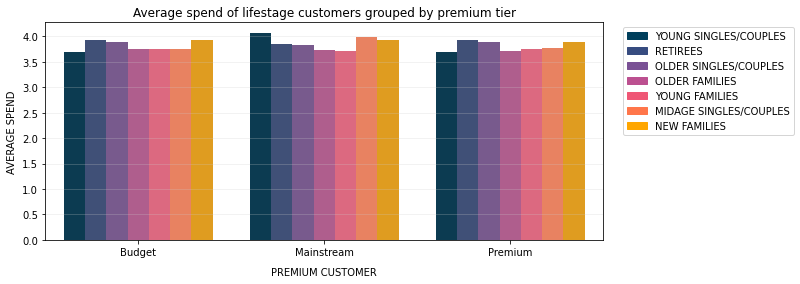

In [49]:
plt.figure(figsize=(10,4))

tierList = ['Budget','Mainstream','Premium']

g = sns.barplot(data=lifestage_premium_sales, 
                x='PREMIUM_CUSTOMER', 
                y='AVE_SPEND', 
                hue='LIFESTAGE',
                palette=colorList,
                order=tierList,
                hue_order=labelList)
g.set_xticklabels(tierList)
plt.title('Average spend of lifestage customers grouped by premium tier')
plt.xlabel('PREMIUM CUSTOMER', labelpad=10)
plt.ylabel('AVERAGE SPEND', labelpad=5)
plt.grid(axis='y', color='0.80', alpha=0.3)
plt.legend(handles=handles, 
           loc="upper right",
           bbox_to_anchor=(1.35,1))
plt.savefig('results_images/task1_customer_avespend.png', bbox_inches='tight', dpi=300)
plt.show()

From our two categories of customer types, we find from the above plot that `YOUNG SINGLES/COUPLES` and `MIDAGE SINGLES/COUPLES` under the `Mainstream` tier are the most likely groups to spend more on chips. `Mainstream` has the largest customer count among the tiers and might have contributed to the calculated average spend of each customer type. 

However, the differences in `AVE_SPEND` for the top 2 customer types (`YOUNG SINGLES/COUPLES Mainstream` and `MIDAGE SINGLES/COUPLES Mainstream`) compared to their `Budget` and `Premium` counterparts does not also seem too large. To know if the difference between these groups are *statistically significant*, we can perform an independent t-test and compare their p-values:

In [50]:
budget = lifestage_premium_sales[lifestage_premium_sales['CUSTOMER_TYPE']\
                        .str.contains('YOUNG SINGLES/COUPLES Budget', case=False)\
                       | lifestage_premium_sales['CUSTOMER_TYPE']\
                        .str.contains('MIDAGE SINGLES/COUPLES Budget', case=False)]['AVE_SPEND']

mainstream = lifestage_premium_sales[lifestage_premium_sales['CUSTOMER_TYPE']\
                        .str.contains('YOUNG SINGLES/COUPLES Mainstream', case=False)\
                       | lifestage_premium_sales['CUSTOMER_TYPE']\
                        .str.contains('MIDAGE SINGLES/COUPLES Mainstream', case=False)]['AVE_SPEND']

premium = lifestage_premium_sales[lifestage_premium_sales['CUSTOMER_TYPE']\
                        .str.contains('YOUNG SINGLES/COUPLES Premium', case=False)\
                       | lifestage_premium_sales['CUSTOMER_TYPE']\
                        .str.contains('MIDAGE SINGLES/COUPLES Premium', case=False)]['AVE_SPEND']

We will be using `ttest_ind()` from `scipy.stats` to perform an independent t-test. **We will attempt to prove or disprove the NULL hypothesis which states that the means of both groups are the same.** The `alpha` is set to be at 0.05 and if the `p-value < 0.05`, then the NULL hypothesis is proven to be FALSE since the chance of the hypothetical mean falling near each other is low.

In [51]:
tstat_bm, pvalues_bm = ttest_ind(budget, mainstream, equal_var=False)
tstat_mp, pvalues_mp = ttest_ind(mainstream, premium, equal_var=False)
tstat_bp, pvalues_bp = ttest_ind(budget, premium, equal_var=False)

print("**P-values of YOUNG SINGLES/COUPLES and MIDAGE SINGLES/COUPLES:**")
if pvalues_bm < 0.05:
    print(f"Budget-Mainstream p-value: {pvalues_bm} < 0.05 --> SIGNIFICANT")
else:
    print(f"Budget-Mainstream p-value: {pvalues_bm} > 0.05 --> NULL HYPOTHESIS CORRECT")
    
if pvalues_mp < 0.05:
    print(f"Mainstream-Premium p-value: {pvalues_mp} < 0.05 --> SIGNIFICANT")
else:
    print(f"Mainstream-Premium p-value: {pvalues_mp} > 0.05 --> NULL HYPOTHESIS CORRECT")
    
if pvalues_bp < 0.05:
    print(f"Budget-Premium p-value: {pvalues_bp} < 0.05 --> SIGNIFICANT")
else:
    print(f"Budget-Premium p-value: {pvalues_bp} > 0.05 --> NULL HYPOTHESIS CORRECT")

**P-values of YOUNG SINGLES/COUPLES and MIDAGE SINGLES/COUPLES:**
Budget-Mainstream p-value: 0.028151782016415102 < 0.05 --> SIGNIFICANT
Mainstream-Premium p-value: 0.03829840169691152 < 0.05 --> SIGNIFICANT
Budget-Premium p-value: 0.7876014765998863 > 0.05 --> NULL HYPOTHESIS CORRECT


From above results, p-value of `Mainstream` `YOUNG SINGLES/COUPLES` and `MIDAGE SINGLES/COUPLES` versus their `Budget` and `Premium` counterparts **both yielded p-values lower than 5%**. This means that the factors contributing to the `AVE_SPEND` of these groups are significant enough to differentiate it from other tier levels.

Moreover, looking at Budget-Premium, the p-value is way higher than the set 5%. This may be due to closer `AVE_SPEND` of the lifestage groups compared to their `Mainstream` counterpart. In this case, differences between `Budget` and `Premium` for `YOUNG SINGLES/COUPLES` and `MIDAGE SINGLES/COUPLES` are negligible.

### Does product size affects average spend of each segment?

In [52]:
prod_size = chip_data_full.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])\
                          .agg({'PROD_QTY':'sum','TOT_SALES':'sum','PROD_SIZE (g)':'mean'})\
                          .reset_index()
prod_size['AVE_SPEND'] = prod_size['TOT_SALES']/prod_size['PROD_QTY']
prod_size.sort_values('PROD_SIZE (g)', ascending=False).head()

,LIFESTAGE,PREMIUM_CUSTOMER,PROD_QTY,TOT_SALES,PROD_SIZE (g),AVE_SPEND
19,YOUNG SINGLES/COUPLES,Mainstream,36225,147582.20,178.344249,4.074043
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,84734.25,177.898693,3.994449
11,OLDER SINGLES/COUPLES,Premium,31695,123537.55,176.485568,3.897698
12,RETIREES,Budget,26932,105916.30,176.395641,3.932731
14,RETIREES,Premium,23266,91296.65,176.368421,3.924037


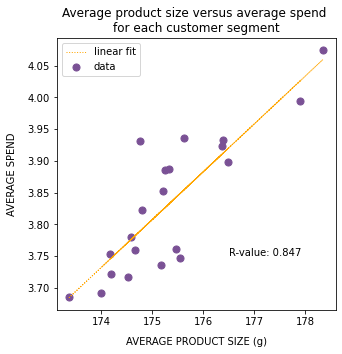

In [54]:
x = prod_size['PROD_SIZE (g)']
y = prod_size['AVE_SPEND']

#plot data points
plt.figure(figsize=(5,5))
plt.scatter(x, y, color='#7a5195', s=50, label='data')
plt.title("Average product size versus average spend \nfor each customer segment")
plt.xlabel("AVERAGE PRODUCT SIZE (g)", labelpad=10)
plt.ylabel("AVERAGE SPEND", labelpad=10)

#plot regression line
regression = linregress(x,y)
y_pred = x*regression.slope + regression.intercept
plt.plot(x, y_pred, linestyle='dotted', linewidth=1, color='#ffa600', label='linear fit')
plt.annotate(f'R-value: {round(regression.rvalue, 3)}', xy=(176.5,3.75))
plt.legend()

plt.savefig('results_images/task1_linearreg_avespend.png', bbox_inches='tight', dpi=300)
plt.show()

Getting the linear regression of `AVE_PROD_SIZE` versus `AVE_SPEND` resulted to a R-value of 0.847 which is near unity. This implies a strong linear correlation for the two variables. Based on this, customers with a high `AVE_SPEND` on chips will also, on average, buy chips of larger size.

### Which chips and brand are preferred for each segment?
What chips/brands are preferred by `YOUNG SINGLES/COUPLES Mainstream` and `MIDAGE SINGLES/COUPLES Mainstream`?

In [56]:
chip_data_full['CUSTOMER_TYPE'] = chip_data_full['LIFESTAGE']+' '+chip_data_full['PREMIUM_CUSTOMER']

In [71]:
def name_freq(customer):
    
    main = chip_data_full[chip_data_full.CUSTOMER_TYPE.str.contains(customer)]
    others = chip_data_full[~chip_data_full.CUSTOMER_TYPE.str.contains(customer)]
    
    main_qty = sum(main['PROD_QTY'])
    others_qty = sum(others['PROD_QTY'])
    
    main_grouped = main.groupby(['PROD_NAME'])\
                       .agg({'TXN_ID':'count','PROD_QTY':'sum','TOT_SALES':'sum'})\
                       .reset_index().rename(columns={'TXN_ID':'TRANX_COUNT'})\
                       [['PROD_NAME','PROD_QTY']]

    others_grouped = others.groupby(['PROD_NAME'])\
                           .agg({'TXN_ID':'count','PROD_QTY':'sum','TOT_SALES':'sum'})\
                           .reset_index().rename(columns={'TXN_ID':'TRANX_COUNT'})\
                           [['PROD_NAME','PROD_QTY']]

    grouped = main_grouped.merge(others_grouped, on=['PROD_NAME'], how='inner')
    grouped['SEGMENT/OTHERS'] = grouped['PROD_QTY_x']/grouped['PROD_QTY_y']
    grouped['AFFINITY'] = (grouped['PROD_QTY_x']/grouped['PROD_QTY_y'])*(others_qty/main_qty)

    #product most likely chosen by segment
    print(grouped[['PROD_NAME','SEGMENT/OTHERS','AFFINITY']]\
                  .sort_values('AFFINITY', ascending=False))

    print(" ")

    main_grouped = main.groupby(['BRAND_NAME'])\
                       .agg({'TXN_ID':'count','PROD_QTY':'sum','TOT_SALES':'sum'})\
                       .reset_index().rename(columns={'TXN_ID':'TRANX_COUNT'})\
                       [['BRAND_NAME','PROD_QTY']]

    others_grouped = others.groupby(['BRAND_NAME'])\
                           .agg({'TXN_ID':'count','PROD_QTY':'sum','TOT_SALES':'sum'})\
                           .reset_index().rename(columns={'TXN_ID':'TRANX_COUNT'})\
                           [['BRAND_NAME','PROD_QTY']]

    grouped = main_grouped.merge(others_grouped, on=['BRAND_NAME'], how='inner')
    grouped['SEGMENT/OTHERS'] = grouped['PROD_QTY_x']/grouped['PROD_QTY_y']
    grouped['AFFINITY'] = (grouped['PROD_QTY_x']/grouped['PROD_QTY_y'])*(others_qty/main_qty)

    #brand name most preferred by segment
    print(grouped[['BRAND_NAME','SEGMENT/OTHERS','AFFINITY']]\
                  .sort_values('AFFINITY', ascending=False))
    
    print(" ")

    main_grouped = main.groupby(['PROD_SIZE (g)'])\
                       .agg({'TXN_ID':'count','PROD_QTY':'sum','TOT_SALES':'sum'})\
                       .reset_index().rename(columns={'TXN_ID':'TRANX_COUNT'})\
                       [['PROD_SIZE (g)','PROD_QTY']]

    others_grouped = others.groupby(['PROD_SIZE (g)'])\
                           .agg({'TXN_ID':'count','PROD_QTY':'sum','TOT_SALES':'sum'})\
                           .reset_index().rename(columns={'TXN_ID':'TRANX_COUNT'})\
                           [['PROD_SIZE (g)','PROD_QTY']]

    grouped = main_grouped.merge(others_grouped, on=['PROD_SIZE (g)'], how='inner')
    grouped['SEGMENT/OTHERS'] = grouped['PROD_QTY_x']/grouped['PROD_QTY_y']
    grouped['AFFINITY'] = (grouped['PROD_QTY_x']/grouped['PROD_QTY_y'])*(others_qty/main_qty)

    #package size most preferred by segment
    print(grouped[['PROD_SIZE (g)','SEGMENT/OTHERS','AFFINITY']]\
                  .sort_values('AFFINITY', ascending=False))

    "-------------Find word frequency:---------------------------------------------"

    banned_names = chip_data_full['BRAND_NAME'].unique().tolist()
    banned_names.extend(['Chip','Chips','And'])

    main_names = main.set_index('PROD_QTY')['PROD_NAME']\
                                 .str.split(expand=True)\
                                 .stack()\
                                 .reset_index()\
                                 .rename(columns={0:'NAME'})
    name_count = main_names[~main_names['NAME']\
                                 .isin(banned_names)]\
                                 .groupby('NAME')\
                                 .agg({'PROD_QTY':'sum'})\
                                 .reset_index()\
                                 .rename(columns={'PROD_QTY':'COUNT'})\
                                 [['NAME','COUNT']]\
                                 .sort_values('COUNT', ascending=False)\
                                 .head(20)
    #plot top 20 words
    plt.figure(figsize=(10,4))
    g = sns.barplot(data=name_count, x='NAME', y='COUNT', color='#7a5195')
    g.set_xticklabels(g.get_xticklabels(), rotation=40)
    plt.title(f'{customer} PRODUCT WORD COUNT')
    plt.xlabel('WORDS', labelpad=10)
    plt.ylabel('WORD COUNT', labelpad=10)
    
    plt.savefig(f'results_images/task1_wordfreq.png', bbox_inches='tight', dpi=300, pad_inches=2)
    plt.show()

For `YOUNG SINGLES/COUPLES Mainstream`:

                              PROD_NAME  SEGMENT/OTHERS  AFFINITY
15   Doritos Corn Chips Cheese Supreme         0.111711  1.338907
91             Tostitos Splash Of Lime         0.110240  1.321284
31      Kettle Mozzarella Basil  Pesto         0.108775  1.303720
92                     Twisties Cheese         0.108358  1.298722
48            Pringles Mystery Flavour         0.107810  1.292157
..                                  ...             ...       ...
83    Sunbites Whlegrn Crisps FrchOnin         0.039969  0.479051
100             WW Original Corn Chips         0.038985  0.467253
99             WW DStyle Chip Sea Salt         0.038722  0.464099
104            Woolworths Cheese Rings         0.037198  0.445830
0                         Burger Rings         0.037011  0.443597

[105 rows x 3 columns]
 
    BRAND_NAME  SEGMENT/OTHERS  AFFINITY
19    Tyrrells        0.102465  1.228095
18    Twisties        0.101733  1.219319
5      Doritos        0.101335  1.214553
9       Kettle    

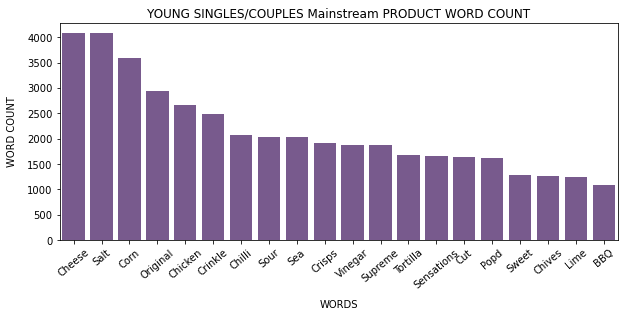

In [72]:
name_freq('YOUNG SINGLES/COUPLES Mainstream')

Among those who bought `Doritos Corn Chips Cheese Supreme`, about 11.17% of them came from `YOUNG SINGLES/COUPLES Mainstream` segment. This segment is also about 34% more likely to buy this chip compared to the rest of the population. When it comes to the chip brand, `YOUNG SINGLES/COUPLES Mainstream` prefer `Tyrells` 23% more than others while they are 56% least likely to buy chips from `Burger Rings` compared to the rest.

In [246]:
chip_data_full[chip_data_full['PROD_SIZE (g)']==270]['PROD_NAME'].unique()

array(['Twisties Cheese ', 'Twisties Chicken'], dtype=object)

Chips of 270g in size are also often preferred by this customer segment and based on the above, `Twisties` is the only brand who have chips in this size. Hence, `YOUNG SINGLES/COUPLES Mainstream` may have a higher likelihood of purchasing `Twisties`.

In [247]:
customer = 'YOUNG SINGLES/COUPLES Mainstream'
main = chip_data_full[chip_data_full.CUSTOMER_TYPE.str.contains(customer)]

print(main.groupby(['PROD_NAME'])\
          .agg({'TXN_ID':'count','PROD_QTY':'sum','TOT_SALES':'sum'})\
          .reset_index().rename(columns={'TXN_ID':'TRANX_COUNT'})\
          [['PROD_NAME','PROD_QTY']]\
          .sort_values('PROD_QTY', ascending=False).head())

print(" ")

print(main.groupby(['BRAND_NAME'])\
          .agg({'TXN_ID':'count','PROD_QTY':'sum','TOT_SALES':'sum'})\
          .reset_index().rename(columns={'TXN_ID':'TRANX_COUNT'})\
          [['BRAND_NAME','PROD_QTY']]\
          .sort_values('PROD_QTY', ascending=False).head())

                              PROD_NAME  PROD_QTY
31      Kettle Mozzarella Basil  Pesto        626
15   Doritos Corn Chips Cheese Supreme        621
91             Tostitos Splash Of Lime        619
40  Kettle Tortilla ChpsHnyJlpno Chili        604
79    Smiths Crnkle Chip Orgnl Big Bag        596
 
   BRAND_NAME  PROD_QTY
9      Kettle      7172
5     Doritos      4447
11   Pringles      4326
14    Smithss      3252
8   Infuzions      2343


Based only by the number of sales, it seems like `YOUNG SINGLES/COUPLES Mainstream` customers prefer to buy `Kettle Mozzarella Basil Pesto` the most, although there is small difference from second (`Doritos Corn Chips Cheese Supreme`) and third (`Tostitos Splash Of Lime`). `Kettle Mozzarella Basil Pesto` was also the overall most bought product among customers which may be due to the high number of customers under `YOUNG SINGLES/COUPLES Mainstream`. Meanwhile, `Kettle` and `Doritos` are the top 2 brand customers in these category usually prefer to buy.

### Other customer types:

                              PROD_NAME  SEGMENT/OTHERS  AFFINITY
70  Smiths Crinkle Chips Salt  Vinegar         0.064319  1.361964
29                       Kettle Chilli         0.063533  1.345311
6                      Cheezels Cheese         0.062323  1.319701
9      Cobs Popd Sour Crm Chives Chips         0.060042  1.271394
16     Doritos Corn Chips Nacho Cheese         0.059495  1.259799
..                                  ...             ...       ...
7                  Cheezels Cheese Box         0.025545  0.540910
82     Snbts Whlgrn Crisps CheddrMstrd         0.024357  0.515756
99             WW DStyle Chip Sea Salt         0.023712  0.502113
83    Sunbites Whlegrn Crisps FrchOnin         0.023062  0.488347
97              WW Crinkle Cut Chicken         0.017660  0.373952

[105 rows x 3 columns]
 
    BRAND_NAME  SEGMENT/OTHERS  AFFINITY
9       Kettle        0.054491  1.153857
18    Twisties        0.054230  1.148326
4         Cobs        0.053973  1.142875
17    Tostitos    

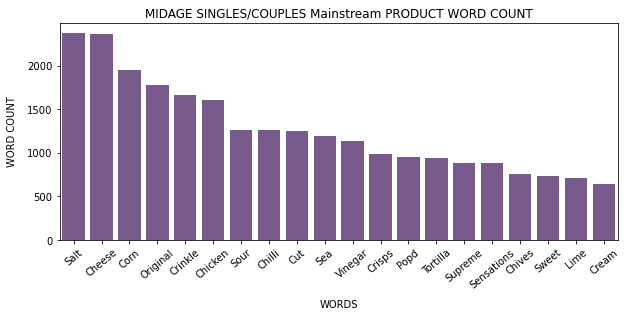

In [73]:
name_freq('MIDAGE SINGLES/COUPLES Mainstream')

                             PROD_NAME  SEGMENT/OTHERS  AFFINITY
48           Pringles Mystery Flavour         0.180370  1.181524
91            Tostitos Splash Of Lime         0.178673  1.170404
31     Kettle Mozzarella Basil  Pesto         0.176221  1.154345
17        Doritos Corn Chips Original         0.175276  1.148154
15  Doritos Corn Chips Cheese Supreme         0.172453  1.129662
..                                 ...             ...       ...
65        Smith Crinkle Cut Bolognese         0.113914  0.746197
72   Smiths Crinkle Cut Chips Chicken         0.112732  0.738453
82    Snbts Whlgrn Crisps CheddrMstrd         0.112104  0.734344
60             RRD Steak  Chimuchurri         0.111604  0.731064
80    Smiths Thinly Cut Roast Chicken         0.105710  0.692457

[105 rows x 3 columns]
 
    BRAND_NAME  SEGMENT/OTHERS  AFFINITY
19    Tyrrells        0.167569  1.097666
18    Twisties        0.166645  1.091617
11    Pringles        0.166019  1.087516
5      Doritos        0.163873

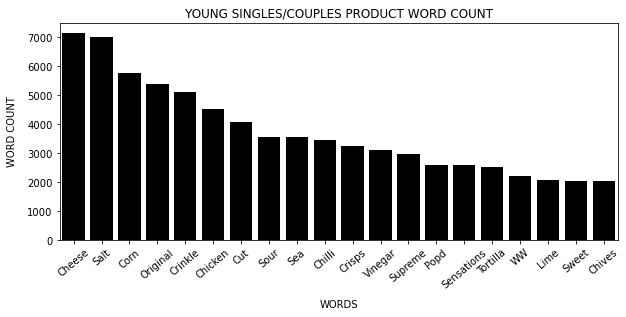

In [249]:
name_freq('YOUNG SINGLES/COUPLES')

                               PROD_NAME  SEGMENT/OTHERS  AFFINITY
40   Kettle Tortilla ChpsHnyJlpno Chili         0.706057  1.131141
16      Doritos Corn Chips Nacho Cheese         0.697694  1.117742
21             Grain Waves Sweet Chilli         0.691251  1.107420
13   Doritos Corn Chip Mexican Jalapeno         0.687328  1.101135
18                     Doritos Mexicana         0.685948  1.098925
..                                   ...             ...       ...
7                   Cheezels Cheese Box         0.528555  0.846773
82      Snbts Whlgrn Crisps CheddrMstrd         0.527366  0.844867
60               RRD Steak  Chimuchurri         0.515102  0.825220
102    WW Sour Cream OnionStacked Chips         0.511327  0.819172
100              WW Original Corn Chips         0.500266  0.801452

[105 rows x 3 columns]
 
    BRAND_NAME  SEGMENT/OTHERS  AFFINITY
4         Cobs        0.672009  1.076593
5      Doritos        0.665380  1.065974
19    Tyrrells        0.662117  1.060745
18    

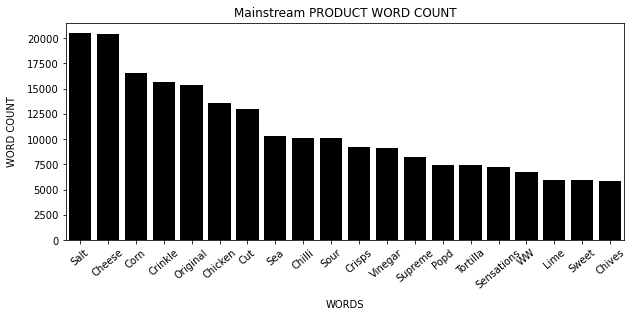

In [250]:
name_freq('Mainstream')

                               PROD_NAME  SEGMENT/OTHERS  AFFINITY
100              WW Original Corn Chips         0.422457  1.182157
60               RRD Steak  Chimuchurri         0.412698  1.154849
24      Infuzions Mango Chutny Papadums         0.396771  1.110280
101           WW Original Stacked Chips         0.394030  1.102609
7                   Cheezels Cheese Box         0.392857  1.099328
..                                   ...             ...       ...
18                     Doritos Mexicana         0.331328  0.927151
70   Smiths Crinkle Chips Salt  Vinegar         0.330573  0.925039
16      Doritos Corn Chips Nacho Cheese         0.321007  0.898269
40   Kettle Tortilla ChpsHnyJlpno Chili         0.320151  0.895874
12               Doritos Cheese Supreme         0.317589  0.888705

[105 rows x 3 columns]
 
    BRAND_NAME  SEGMENT/OTHERS  AFFINITY
0       Burger        0.388499  1.087133
20  Woolworths        0.379176  1.061044
15    Sunbites        0.377875  1.057402
1     

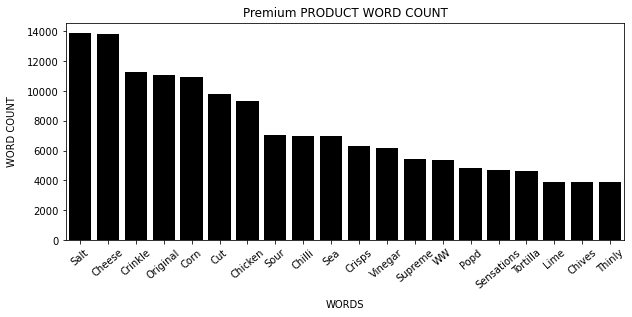

In [251]:
name_freq('Premium')

                               PROD_NAME  SEGMENT/OTHERS  AFFINITY
75   Smiths Crinkle Cut French OnionDip         0.659522  1.211933
97               WW Crinkle Cut Chicken         0.640569  1.177105
99              WW DStyle Chip Sea Salt         0.637819  1.172050
74    Smiths Crinkle Cut Chips Original         0.636418  1.169476
66       Smith Crinkle Cut Mac N Cheese         0.624788  1.148105
..                                   ...             ...       ...
26  Infuzions Thai SweetChili PotatoMix         0.500846  0.920351
10     Cobs Popd SwtChlli SrCream Chips         0.499161  0.917255
9       Cobs Popd Sour Crm Chives Chips         0.495665  0.910830
34           Kettle Sensations BBQMaple         0.493556  0.906954
30             Kettle Honey Soy Chicken         0.491102  0.902446

[105 rows x 3 columns]
 
    BRAND_NAME  SEGMENT/OTHERS  AFFINITY
6       French        0.622468  1.143842
15    Sunbites        0.610640  1.122106
13      Smiths        0.609931  1.120805
20  Wo

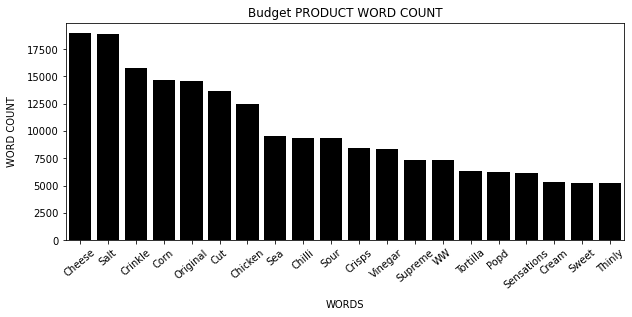

In [252]:
name_freq('Budget')

## Summary and Recommendations:

Based on the above data and analysis, `Mainstream` has the largest sample size among customers and also have the highest `AVE_SPEND` compared to others. `Mainstream` customers usually prefer Kettle, Smiths and Doritos are their chip brand and will often choose products that have salt, cheese and corn in their names. 

Under this tier, `YOUNG SINGLES/COUPLES` dominate the numbers. If we are looking to drive higher sales, we can also target more people which falls in this segment by offering products which they are more likely to buy. For this, we find that `YOUNG SINGLES/COUPLES Mainstream` are willing to spend the highest on chips and generally will prefer larger package sizes. They also tend to choose `Kettle` as their brand of choice with `Kettle Mozzarella Basil Pesto` as the most popular among them. As for the kinds of chips they like, we find that chips with cheese, salt, corn, original, or chicken on their product names are most likely bought than others. 

*--- Add results from getting segment/others and affinity metrics (see edits below) ---*

## Other questions to explore further:
- Which products are frequently bought together? This might include other chip products or other products in general.
- In relation to the above, how much does each customer segment spend on chips alone as compared to other products they buy? For this we might need more data on what other products do customers buy within a 1-year time range.

-------------

## Edits after reviewing solution:
- Added the affinity metric. I was confused at first on how it was calculated and I previously didn't think of getting the sales compared to the rest of the population for each segment. This is quite significant since total sales are more straightforward but might not give more specifics about customer segmentation.
- Added time-series plot for date versus number of transactions to directly visualize the missing date.
- There are some brand names which I did not thoroughly cleaned. I should have researched each brand name and compare if there are any duplicates -- which turns out there are (quite a lot of them!). This should serve as reminder to always utilize research especially for pieces of information that are not as familiar.

*Last edit: January 19, 2023*